#**Reconocedor de puntos clave faciales con Python**

Ejemplo de implementación utilizando OpenCV y Redes Neuronales Convolucionales.


**Paso 1 :** Detectar las caras a partir de modelos definidos en OpenCV.

**Paso 2 :** Definición y entrenamiento de una Red Neuronal Convolucional (CNN) en Keras.


In [87]:
#!pip install opencv-
#!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=693acfb7630b071005d5245a4dd6d6ddf5f453fd7482bf332ccda8f38d622f68
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [66]:
# Import required libraries for this section

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time

from keras.models import load_model

In [67]:
# Funciones auxiliares

def read_image(path):
    """ Metodo para leer las imagenes desde la matriz """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_image(image, title=''):
    """ Traza una imagen tal como está en un gráfico de una sola columna"""
    # Plot our image using subplots to specify a size and title
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_title(title)
    ax1.imshow(image)

#**Paso 1: Detectar las caras a partir de modelos definidos en OpenCV**

Definición de los métodos que utilizaremos.

get_faces: A partir de una imagen se devuelve el conjunto de caras detectadas

plot_faces: Muestra las caras detectadas sobre la imagen original

In [84]:
def get_faces(image):
    """
    Devuelve un array con los rostros detectados en una imagen.
    Cada cara se define como lo hace OpenCV: x superior izquierda, y superior izquierda, ancho y alto
    """
    # Evita sobrescribir las imagenes

    image_copy = np.copy(image)

    # El filtro funciona con imágenes en escala de grises.
    gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # Extrae el detector de rostros previamente entrenado de un archivo xml
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # detecta los rostros de una imagen
    faces = face_classifier.detectMultiScale(gray, 1.2, 5)

    return faces

def draw_faces(image, faces=None, plot=True):
    """
    Traza una imagen con sus caras detectadas. Si faces es Ninguna, también calcula las caras.
    """
    if faces is None:
        faces = get_faces(image)

    # Evita sobrescribir las imagenes
    image_with_faces = np.copy(image)

    # Obtenga el cuadro delimitador para cada rostro detectado
    for (x,y,w,h) in faces:
        # Agrega un cuadro a la imagen
        cv2.rectangle(image_with_faces, (x,y), (x+w,y+h), (255,0,0), 3)

    if plot is True:
        plot_image(image_with_faces)
    else:
        return image_with_faces



def plot_image_with_keypoints(image, image_info):
    """
    Traza puntos clave dados en formato (x,y)
    """
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)

    for (face, keypoints) in image_info:
        for (x,y) in keypoints:
            ax1.scatter(x, y, marker='o', c='c', s=10)


    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(image)


Faces detected: 9


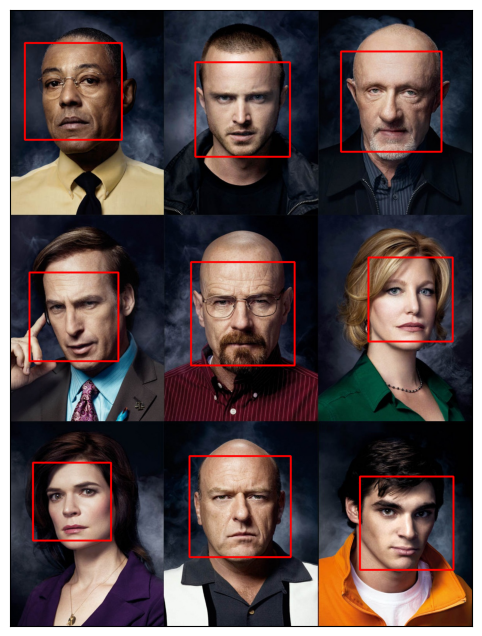

In [85]:
image = read_image('/content/drive/MyDrive/Topicos avanzados/breaking_bad.jpg')
faces = get_faces(image)
print("Faces detected: {}".format(len(faces)))
draw_faces(image, faces)

#**Paso 2: Definición y entrenamiento de una Red Neuronal Convolucional (CNN) en Keras**
En este paso se define una red neuronal convolucional para sacar los keypoints de cada una de las fotos detectadas. La implementación se realizará en Keras, usando Tensorflow como backend.

Para poder hacer uso del conocimiento de la red neuronal hay que entrenarla con datos previos. En kaggle podemos encontrar este dataset que contiene 60MB de imágenes, cada una con un tag en los keypoints.

Estos keypoints serán 15: 4 en la boca, 1 en la nariz, 3 en cada ojo y 2 en cada ceja.

Lo primero que haremos será cargar estas imágenes y prepararlas para el entrenamiento

In [97]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

def load_data(test=False):
    """
    Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Important that the files are in a `data` directory
    """
    FTRAIN = '/content/drive/MyDrive/Topicos avanzados/training.csv'
    FTEST = '/content/drive/MyDrive/Topicos avanzados/test.csv'
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load dataframes

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1

    if not test:  # only FTRAIN has target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

def plot_data(img, landmarks, axis):
    """
    Plot image (img), along with normalized facial keypoints (landmarks)
    """
    axis.imshow(np.squeeze(img), cmap='gray') # plot the image
    landmarks = landmarks * 48 + 48 # undo the normalization
    # Plot the keypoints
    axis.scatter(landmarks[0::2],
        landmarks[1::2],
        marker='o',
        c='c',
        s=40)

def plot_keypoints(img_path,
                  face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_alt.xml'),
                  model_path='my_model.h5'):
    # TODO: write a function that plots keypoints on arbitrary image containing human
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    ax.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))

    if len(faces) == 0:
        plt.title('no faces detected')
    elif len(faces) > 1:
        plt.title('too many faces detected')
        for (x,y,w,h) in faces:
            rectangle = cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2)
            ax.imshow(cv2.cvtColor(rectangle, cv2.COLOR_BGR2RGB))
    elif len(faces) == 1:
        plt.title('one face detected')
        x,y,w,h = faces[0]
        bgr_crop = img[y:y+h, x:x+w]
        orig_shape_crop = bgr_crop.shape
        gray_crop = cv2.cvtColor(bgr_crop, cv2.COLOR_BGR2GRAY)
        resize_gray_crop = cv2.resize(gray_crop, (96, 96)) / 255.
        model = load_model(model_path)
        landmarks = np.squeeze(model.predict(
            np.expand_dims(np.expand_dims(resize_gray_crop, axis=-1), axis=0)))
        ax.scatter(((landmarks[0::2] * 48 + 48)*orig_shape_crop[0]/96)+x,
                   ((landmarks[1::2] * 48 + 48)*orig_shape_crop[1]/96)+y,
                   marker='o', c='c', s=40)
    plt.show()

In [98]:
from utils import *


# Load training set
# load_data es un método definido en el fichero utils para cargar las imágenes.
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


# **Visualización de los datos de entrenamiento**

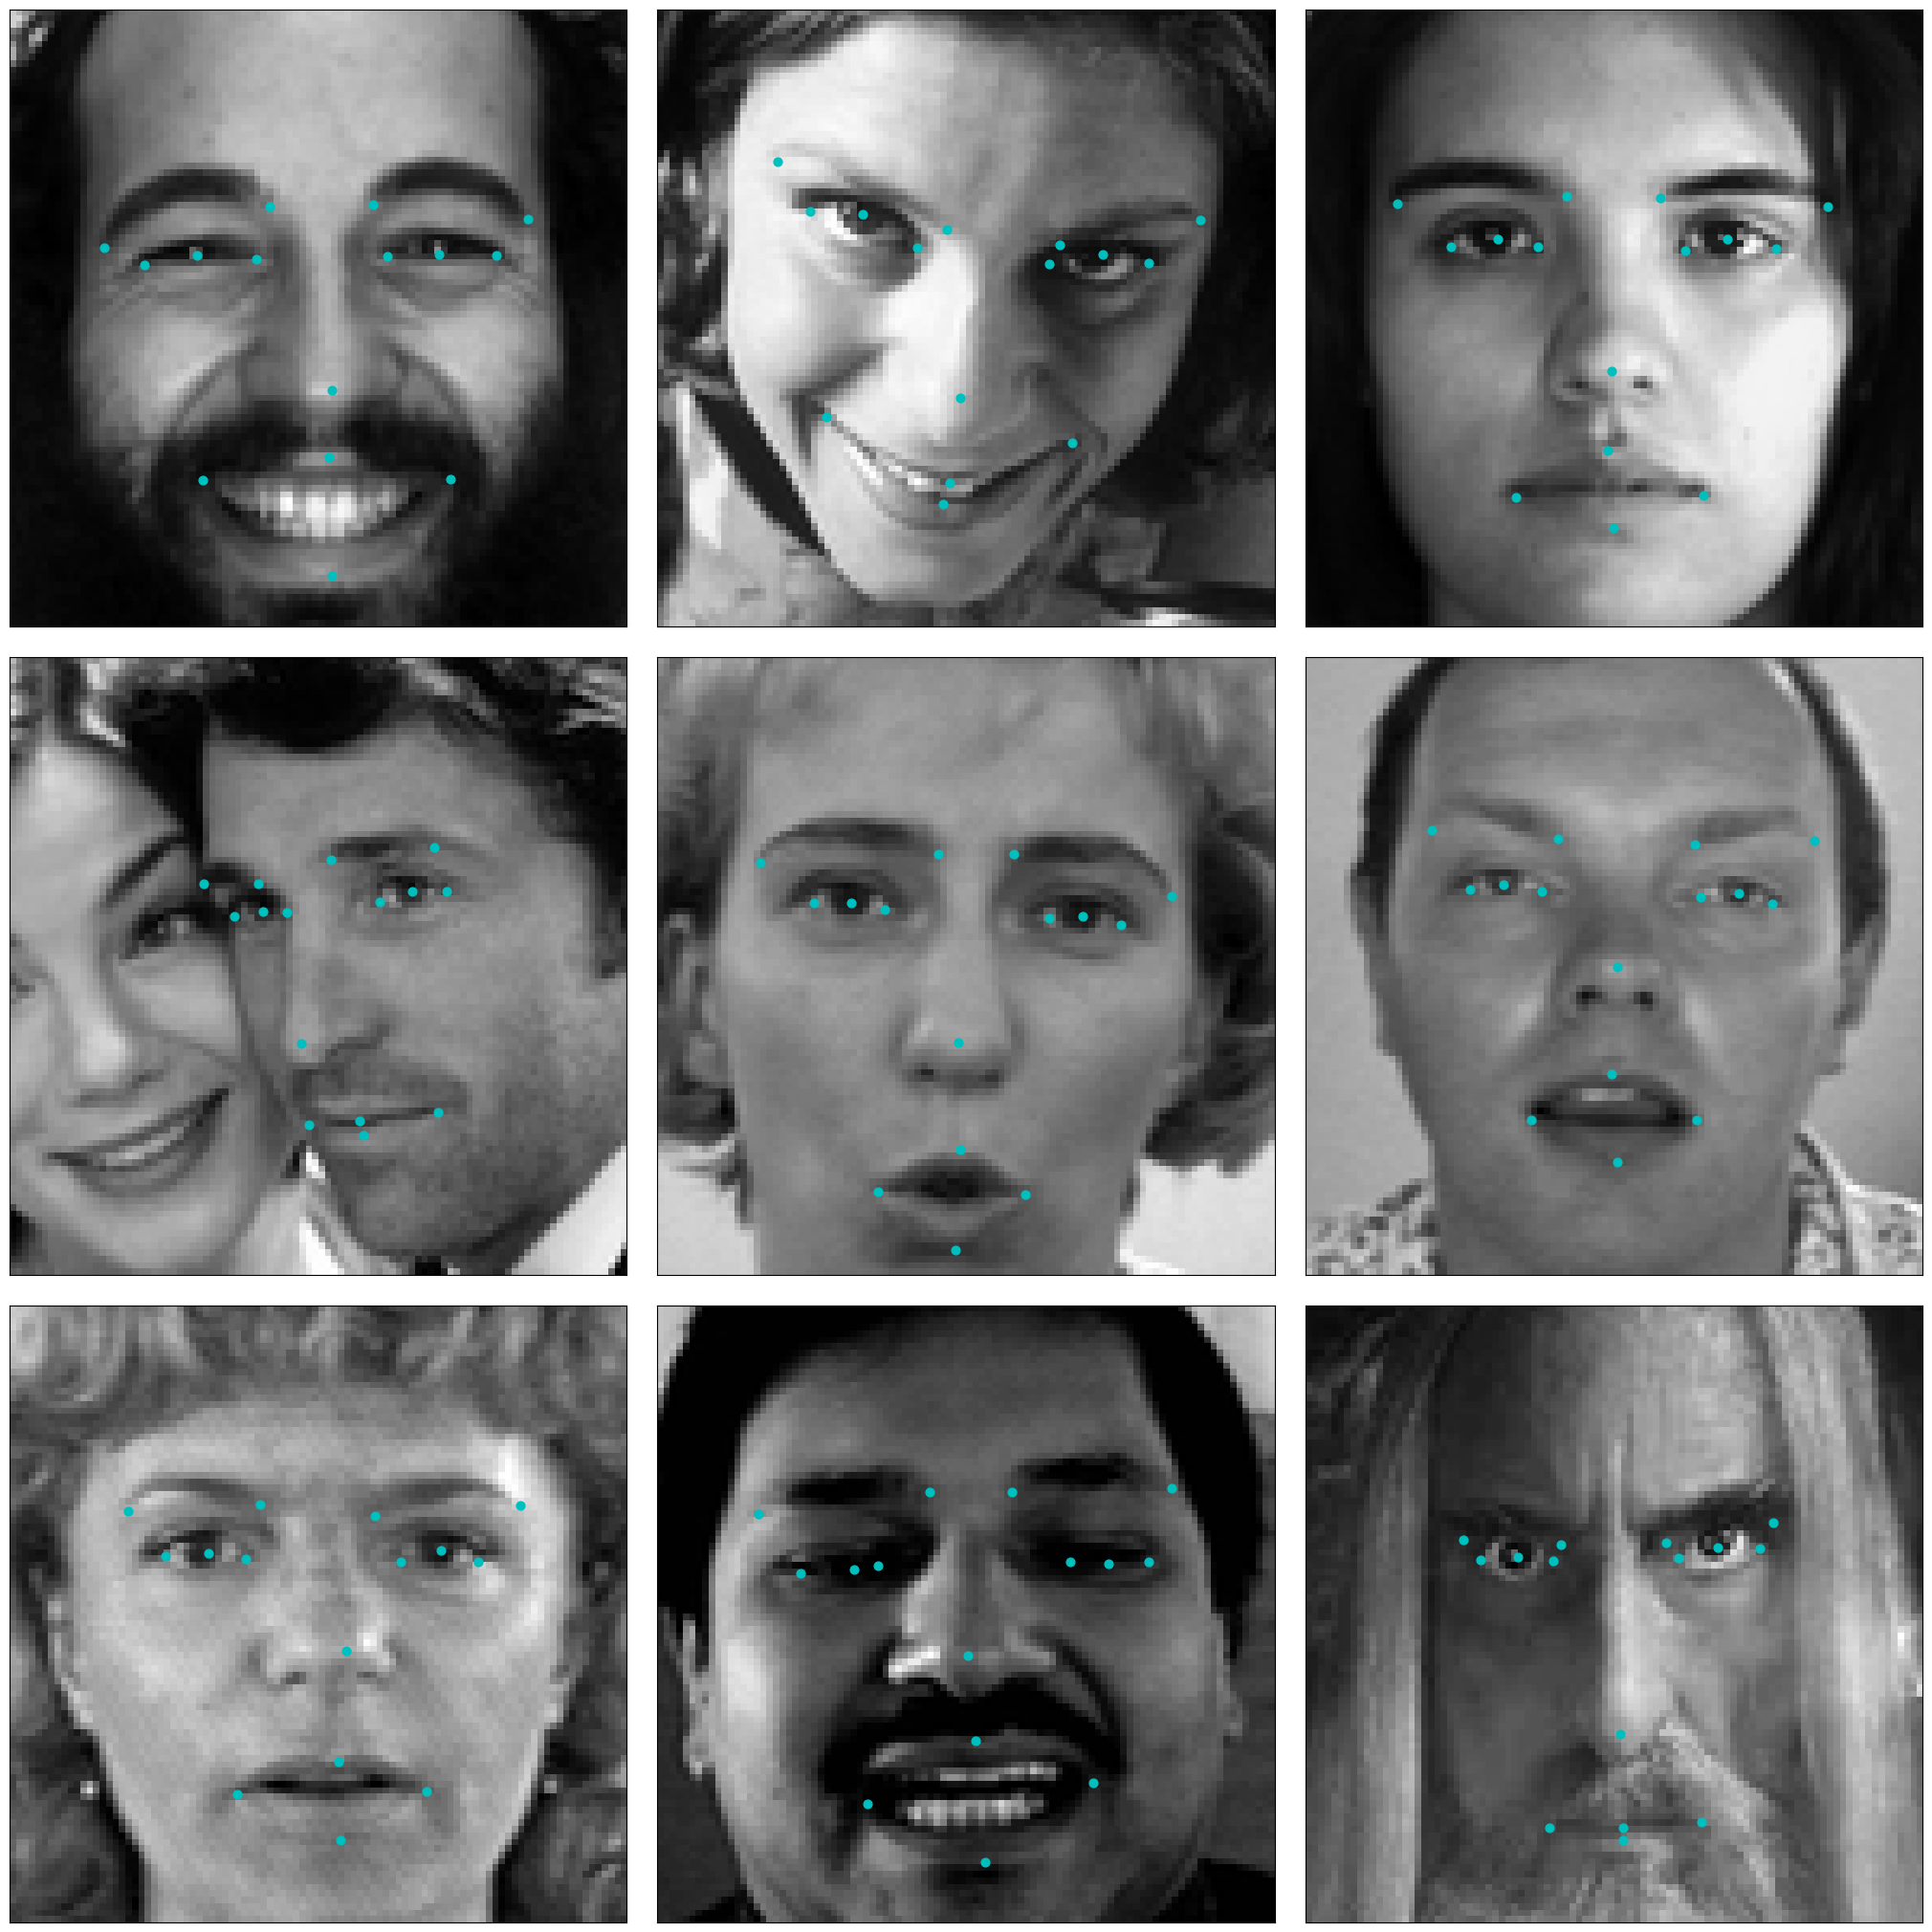

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

#**Definición de la Red Neuronal Convolucional**
La red neuronal definida tiene una complejidad básica-media. No es el objetivo entenderla al 100%. Puede ser interesante ver cómo se alternan capas convolucionales que dan profundidad a la red con capas de "pooling", que reducen el tamaño de las imágenes.

También se puede ver cómo se han añadido capas de Dropout (descarte de un porcentaje de los resultados intermedios) para evitar el overfitting.

Al final se termina con una capa densa de 30 valores, un valor por cada posición "x" e "y" de los 15 keypoints

In [100]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense

# Su modelo debe aceptar imágenes en venta en gris de 96x96 píxeles en
# Debería tener una capa de salida completamente conectada con 30 valores (2 para cada punto clave facial)

shape = (96,96)
model = Sequential()
model.add(Convolution2D(16,(2,2),padding='same',input_shape=(96,96, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=3))

model.add(Convolution2D(32,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Convolution2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Convolution2D(128,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(30))


# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 10, 10, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        1

# **Compilación y entrenamiento de la Red Neuronal Convolucional**
Para compilar y entrenar una red neuronal hay un millón de combinaciones posibles dependiendo de la configuración de lo que se denominan "hiperparámetros".

Tampoco es objeto de estudio la optimización de una red neuronal, por lo que se han realizado diferentes pruebas y los mejores resultados obtenidos han sido los siguientes (¡te animamos a que pruebes los tuyos!):

optimizer: adam

loss: mse

batch_size: 20

validation:split: 0.2

In [102]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import ModelCheckpoint, History

epochs = 50
histo = History()

## Compile the model
def compile_model(model, epochs):

    filepath = 'model.hdf5'
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath=filepath,
                                   verbose=1, save_best_only=True)

    ## Train the model
    hist = model.fit(X_train, y_train, validation_split=0.2,
              epochs=epochs, batch_size=20, callbacks=[checkpointer, histo], verbose=1)

    model.save(filepath)

    return hist

def show_training_validation_loss(hist, epochs):
    plt.plot(range(epochs), hist.history[
             'val_loss'], 'g-', label='Val Loss')
    plt.plot(range(epochs), hist.history[
             'loss'], 'g--', label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# TODO: Set True if you want to train the network. It will get a pretrained network values from a file.
train_net = False

if train_net is True:
    hist = compile_model(model, epochs)
else:
    model.load_weights('/content/drive/MyDrive/Topicos avanzados/model.hdf5')

In [105]:
# Visualize the training and validation loss of the neural network
if train_net is True:
    show_training_validation_loss(hist, epochs)